In [1]:
%load_ext autoreload
%matplotlib inline

/Users/diego/.pyenv/versions/miniconda-latest/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


In [2]:
%autoreload 2

from IPython import display

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from utils import Logger

import tensorflow as tf
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import numpy as np

In [3]:
DATA_FOLDER = './tf_data/DCGAN/CIFAR'

## Load Data

In [4]:
def cifar_data():
    compose = transforms.Compose(
        [
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5)),
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

In [5]:
dataset = cifar_data()
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

Files already downloaded and verified


In [6]:
IMAGES_SHAPE = (64, 64, 3)
NOISE_SIZE = 100

## Models 

##### Ops

In [7]:
def default_conv2d(inputs, filters):
    return layers.conv2d(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def default_conv2d_transpose(inputs, filters):
    return layers.conv2d_transpose(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

#### Discriminator

In [8]:
def discriminator(x):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("conv1"):
            conv1 = default_conv2d(x, 128)
            conv1 = nn.leaky_relu(conv1,alpha=0.2)
        
        with tf.variable_scope("conv2"):
            conv2 = default_conv2d(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.leaky_relu(conv2,alpha=0.2)
            
        with tf.variable_scope("conv3"):
            conv3 = default_conv2d(conv2, 512)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.leaky_relu(conv3,alpha=0.2)
            
        with tf.variable_scope("conv4"):
            conv4 = default_conv2d(conv3, 1024)
            conv4 = layers.batch_normalization(conv3)
            conv4 = nn.leaky_relu(conv3,alpha=0.2)
        
        with tf.variable_scope("linear"):
            linear = clayers.flatten(conv4)
            linear = clayers.fully_connected(linear, 1)
        
        with tf.variable_scope("out"):
            out = nn.sigmoid(linear)
    return out

#### Generator

In [9]:
def generator(z):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        
        with tf.variable_scope("linear"):
            linear = clayers.fully_connected(z, 1024 * 4 * 4)
            
        with tf.variable_scope("conv1_transp"):
            # Reshape as 4x4 images
            conv1 = tf.reshape(linear, (-1, 4, 4, 1024))
            conv1 = default_conv2d_transpose(conv1, 512)
            conv1 = layers.batch_normalization(conv1)
            conv1 = nn.relu(conv1)
        
        with tf.variable_scope("conv2_transp"):
            conv2 = default_conv2d_transpose(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.relu(conv2)
            
        with tf.variable_scope("conv3_transp"):
            conv3 = default_conv2d_transpose(conv2, 128)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.relu(conv3)
            
        with tf.variable_scope("conv4_transp"):
            conv4 = default_conv2d_transpose(conv3, 3)
        
        with tf.variable_scope("out"):
            out = tf.tanh(conv4)
    return out

## Graph Optimization

#### Inputs

In [10]:
## Real Input
X = tf.placeholder(tf.float32, shape=(None, )+IMAGES_SHAPE)
## Latent Variables / Noise
Z = tf.placeholder(tf.float32, shape=(None, NOISE_SIZE))

#### Outputs

In [11]:
# Generator
G_sample = generator(Z)
# Discriminator
D_real = discriminator(X)
D_fake = discriminator(G_sample)

#### Losses

In [12]:
# Generator
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.ones_like(D_fake)
    )
)

# Discriminator
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_real, labels=tf.ones_like(D_real)
    )
)

D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.zeros_like(D_fake)
    )
)

D_loss = D_loss_real + D_loss_fake

#### Optimizers

In [13]:
# Obtain trainable variables for both networks
train_vars = tf.trainable_variables()

G_vars = [var for var in train_vars if 'generator' in var.name]
D_vars = [var for var in train_vars if 'discriminator' in var.name]

num_epochs = 200

In [14]:
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_vars,)
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_vars,)

## Training

#### Testing

In [15]:
num_test_samples = 16
test_noise = noise(num_test_samples, NOISE_SIZE)

#### Inits

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 200

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Init Logger
logger = Logger(model_name='DCGAN1', data_name='CIFAR10')

#### Train

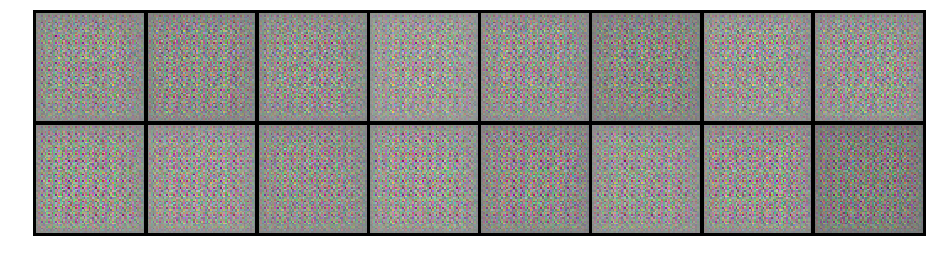

Epoch: [0/200], Batch Num: [0/500]
(1.447016, 0.4735532)
Discriminator Loss: 1.4470, Generator Loss: 0.4736
D(x): 0.5030, D(G(z)): 0.5000


In [ ]:
# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()

# Iterate through epochs
for epoch in range(NUM_EPOCHS):
    for n_batch, (batch,_) in enumerate(dataloader):
        
        # 1. Train Discriminator
        X_batch = batch.permute(0, 2, 3, 1).numpy()
        feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
        )

        # 2. Train Generator
        feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, g_error = session.run(
            [G_opt, G_loss], feed_dict=feed_dict
        )
        
        if n_batch % 100 == 0:
            display.clear_output(True)
            # Generate images from test noise
            test_images = session.run(
                G_sample, feed_dict={Z: test_noise}
            )
            # Log Images
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches, format='NHWC');
            # Log Status
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )